In [27]:
import os
import sys
import shutil
import glob

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex = True)

#plt.rcParams.update(  # try to match font sizes of document
#  {'axes.labelsize': 20,
#   'axes.titlesize': 20,
#   'legend.fontsize': 20,
#   'xtick.labelsize': 20,
#   'ytick.labelsize': 20,
#   'text.usetex': True,
#   'font.family': 'serif',
#   'font.serif': ['palatino'],
#   'savefig.dpi': 300
#   })

%pylab inline

from glue.ligolw import ligolw
from glue.ligolw import table
from glue.ligolw import lsctables
from glue.ligolw import ilwd
from glue.ligolw import utils as ligolw_utils

import pycbc.strain
import pycbc.psd
from pycbc.pnutils import mass1_mass2_to_mchirp_eta
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_two_pol_waveform_filter, get_td_waveform
from pycbc import DYN_RANGE_FAC
from pycbc.types import FrequencySeries, zeros
from pycbc.filter import match, overlap, sigma, make_frequency_series
from pycbc.scheme import CPUScheme, CUDAScheme
from pycbc import pnutils

#from GWNRTools.Utils.SupportFunctions import make_padded_frequency_series
#from GWNRTools.DataAnalysis import get_unique_hex_tag
#import GWNRTools.DataAnalysis as DA


Populating the interactive namespace from numpy and matplotlib


##### Creating .ini file for injections

In [3]:
with open("banksim.ini", 'a') as fout:
    fout.write("""\
[inspinj]
f-lower = 15 
i-distr = fixed
fixed-inc = 0
min-mass1 = 3. 
max-mass1 = 25. 
m-distr = componentMass 
disable-milkyway =
min-mass2 = 3. 
max-mass2 = 25. 
min-distance = 1000  
l-distr = random  
min-mtotal = 6
waveform = EOBNRv2
aligned = 
enable-spin =
;max-mtotal = 
min-spin1 = 0 
max-spin1 = 0 
min-spin2 = 0 
max-spin2 = 0
max-distance = 1000 
d-distr = uniform 
gps-start-time = 1000000000 
gps-end-time =   1000010000
time-interval = 0. 
time-step = 1. 
seed = 3 

[executables]
banksim = /cvmfs/oasis.opensciencegrid.org/ligo/sw/pycbc/x86_64_rhel_7/virtualenv/pycbc-v1.16.10/bin/pycbc_banksim

[workflow]
accounting-group = ligo.dev.o3.cbc.explore.test
log-path = /home/isha.anantpurkar/NonSpinTmplBank/LowMassPaper-BankEffectualness/EOB_EOB_correct/logs/
;use-gpus =
bank-file = LowMass.xml
injections-per-job = 50
templates-per-job = 100 

[banksim]
psd-model = aLIGOZeroDetHighPower 
template-approximant = EOBNRv2 
template-phase-order = 7 
template-amplitude-order = 0 
;template-spin-order =
template-start-frequency = 40
signal-approximant = EOBNRv2
signal-phase-order = 7 
signal-amplitude-order = 0 
;signal-spin-order = 0
signal-start-frequency = 30
filter-low-frequency = 40 
filter-sample-rate = 16384
filter-signal-length = 128
mchirp-window = 0.10
""")

#### Images

In [4]:
from IPython.display import Image

In [5]:
! ls plots

cum_hist.png		 m1-m2-mchirpdiff.png	  q-s2z-match90.png
hist-match-cum.png	 m1-m2-mchirpreldiff.png  q-s2z-match97.png
hist-match.png		 q-s1m-match.png	  q-s2z-match.png
hist-mchirp-diff.png	 q-s1z-match.png	  q-s2z-mchirpdiff.png
hist-mchirp-reldiff.png  q-s1z-mchirpdiff.png	  q-s2z-mchirpreldiff.png
inc-match.png		 q-s1z-mchirpreldiff.png  tm1-tm2-match.png
m1-m2-match.png		 q-s2m-match.png


In [3]:
bank_filename = 'LowMass.xml'
xml_doc = ligolw_utils.load_filename(bank_filename, contenthandler=table.use_in(ligolw.LIGOLWContentHandler), verbose=True)
sngl_inspiral_table = lsctables.SnglInspiralTable.get_table(xml_doc)

reading 'LowMass.xml' ...
md5sum: 1472c7b9379a769ffab4625b89dee6f3  LowMass.xml


In [4]:
m1 = np.array([sngl_wf.mass1 for sngl_wf in sngl_inspiral_table])
m2 = np.array([sngl_wf.mass2 for sngl_wf in sngl_inspiral_table])

Text(0, 0.5, 'mass 2')

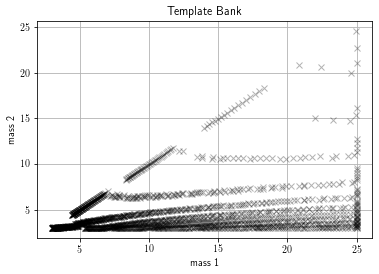

In [5]:
plt.figure()
plt.plot(m1, m2, 'kx', alpha=0.3)
plt.grid()
plt.title("Template Bank")
plt.xlabel('mass 1')
plt.ylabel('mass 2')

In [6]:
import numpy as np

In [28]:
res = np.loadtxt('results.dat')

match = res[:,0]
tmass1 = res[:,1]
tmass2 = res[:,2]
tspin1x = res[:,3] 
tspin1y = res[:,4]
tspin1z = res[:,5]
tspin2x = res[:,6]
tspin2y = res[:,7]
tspin2z = res[:,8]
tmchirp, teta = pnutils.mass1_mass2_to_mchirp_eta(tmass1, tmass2)

imass1 = res[:,9]
imass2 = res[:,10]
ispin1x = res[:,11]
ispin1y = res[:,12]
ispin1z = res[:,13]
ispin2x = res[:,14]
ispin2y = res[:,15]
ispin2z = res[:,16]
imchirp, ieta = pnutils.mass1_mass2_to_mchirp_eta(imass1, imass2)

In [29]:
match_isnan = np.isnan(match)
match[match_isnan]

array([], dtype=float64)

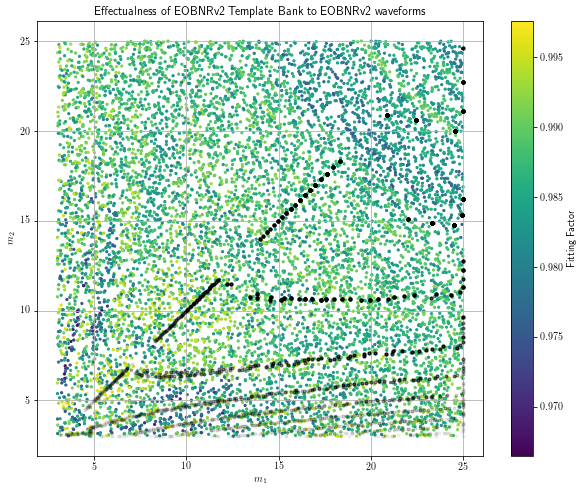

In [53]:
plt.figure(figsize = (10,8))
plt.scatter(imass1, imass2, c = match, s=5)
plt.colorbar(label="Fitting Factor")
plt.plot(tmass1, tmass2, 'k.', alpha=0.05)
plt.grid()
plt.title("Effectualness of EOBNRv2 Template Bank to EOBNRv2 waveforms")
plt.xlabel('$m_1$')
plt.ylabel('$m_2$')
plt.savefig("EffectualnessEOBNRv2.png")

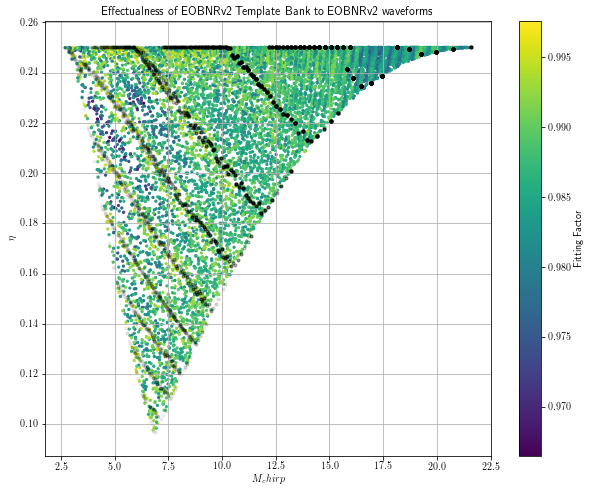

In [54]:
plt.figure(figsize = (10,8))
plt.scatter(imchirp, ieta, c = match, s=5)
plt.colorbar(label = "Fitting Factor")
plt.plot(tmchirp, teta, 'k.', alpha=0.05)
plt.grid()
plt.title("Effectualness of EOBNRv2 Template Bank to EOBNRv2 waveforms")
plt.xlabel('$M_chirp$')
plt.ylabel('$\eta$')
plt.savefig("EffectualnessEOBNRv2-eta-mchirp-coords.png")

Text(0, 0.5, 'total mass')

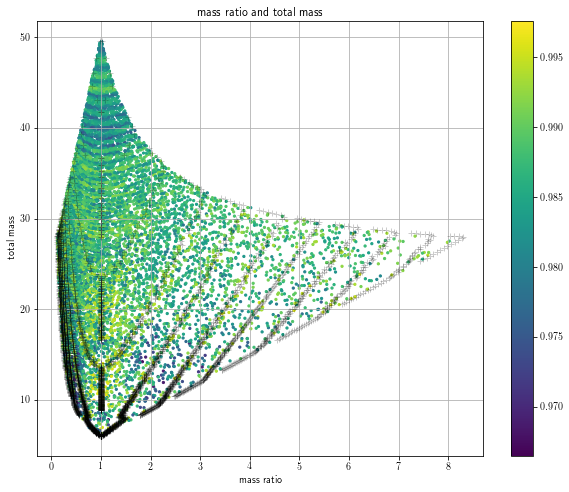

In [40]:
q = imass1/imass2
M = imass1+imass2

plt.figure(figsize = (10,8))
plt.scatter(q, M, c = match, s=5)
plt.colorbar()
plt.plot(m2/m1, m1+m2, 'k+', alpha=0.2)
plt.plot(m1/m2, m1+m2, 'k+', alpha=0.2)
plt.grid()
plt.title("mass ratio and total mass")
plt.xlabel('mass ratio')
plt.ylabel('total mass')

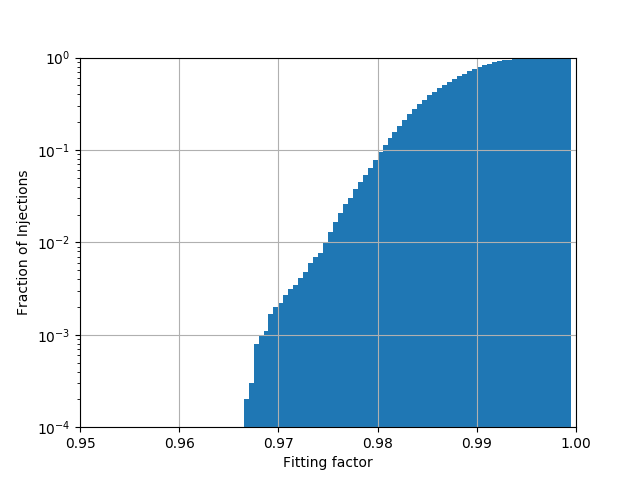

In [13]:
Image('plots/cum_hist.png')

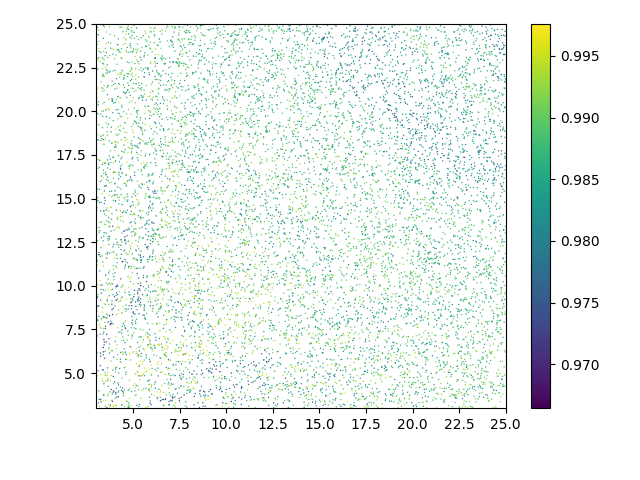

In [14]:
Image('plots/m1-m2-match.png')

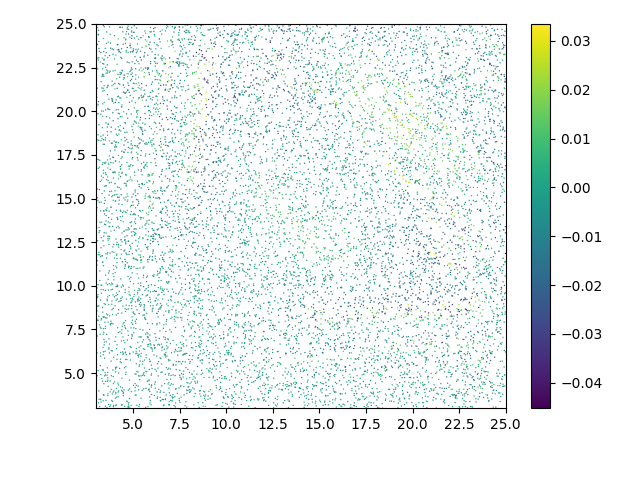

In [6]:
Image('plots/m1-m2-mchirpreldiff.png')